#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 05
**CH05A What Likelihood of Loss to Expect on a Stock Portfolio?**

using the sp500 dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/sp500/clean/"
data_out = dirname + "da_case_studies/ch05-stock-market-loss-generalize/"
output = dirname + "da_case_studies/ch05-stock-market-loss-generalize/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
sp500 = pd.read_csv("/workspaces/codespaces-jupyter/data/SP500_2006_16_data.csv")
sp500# sp500 = pd.read_csv("https://osf.io/h64z2/download")

,DATE,VALUE
0,2006-08-25,1295.09
1,2006-08-28,1301.78
2,2006-08-29,1304.28
3,2006-08-30,1304.27
4,2006-08-31,1303.82
...,...,...
2606,2016-08-22,2182.64
2607,2016-08-23,2186.90
2608,2016-08-24,2175.44
2609,2016-08-25,2172.47


In [4]:
sp500 = sp500.replace("", np.nan).replace("#N/A", np.nan).dropna().reset_index(drop=True)

Create percent return

In [5]:
#Fractional change between the current and a prior element. Examples below
sp500["pct_return"] = sp500["VALUE"].pct_change() * 100

In [6]:
#Fractial change in action
s = pd.Series([90, 91, None, 85])
s.ffill().pct_change()

0         NaN
1    0.011111
2    0.000000
3   -0.065934
dtype: float64

Create date variables (we dont use these though)

In [7]:
sp500["DATE"] = pd.to_datetime(sp500["DATE"], format="%Y-%m-%d")
sp500["year"] = sp500["DATE"].dt.year
sp500["month"] = sp500["DATE"].dt.month
sp500["yearmonth"] = sp500["year"] * 100 + sp500["month"]

### Figure 5.1 Histogram of daily returns in the entire data

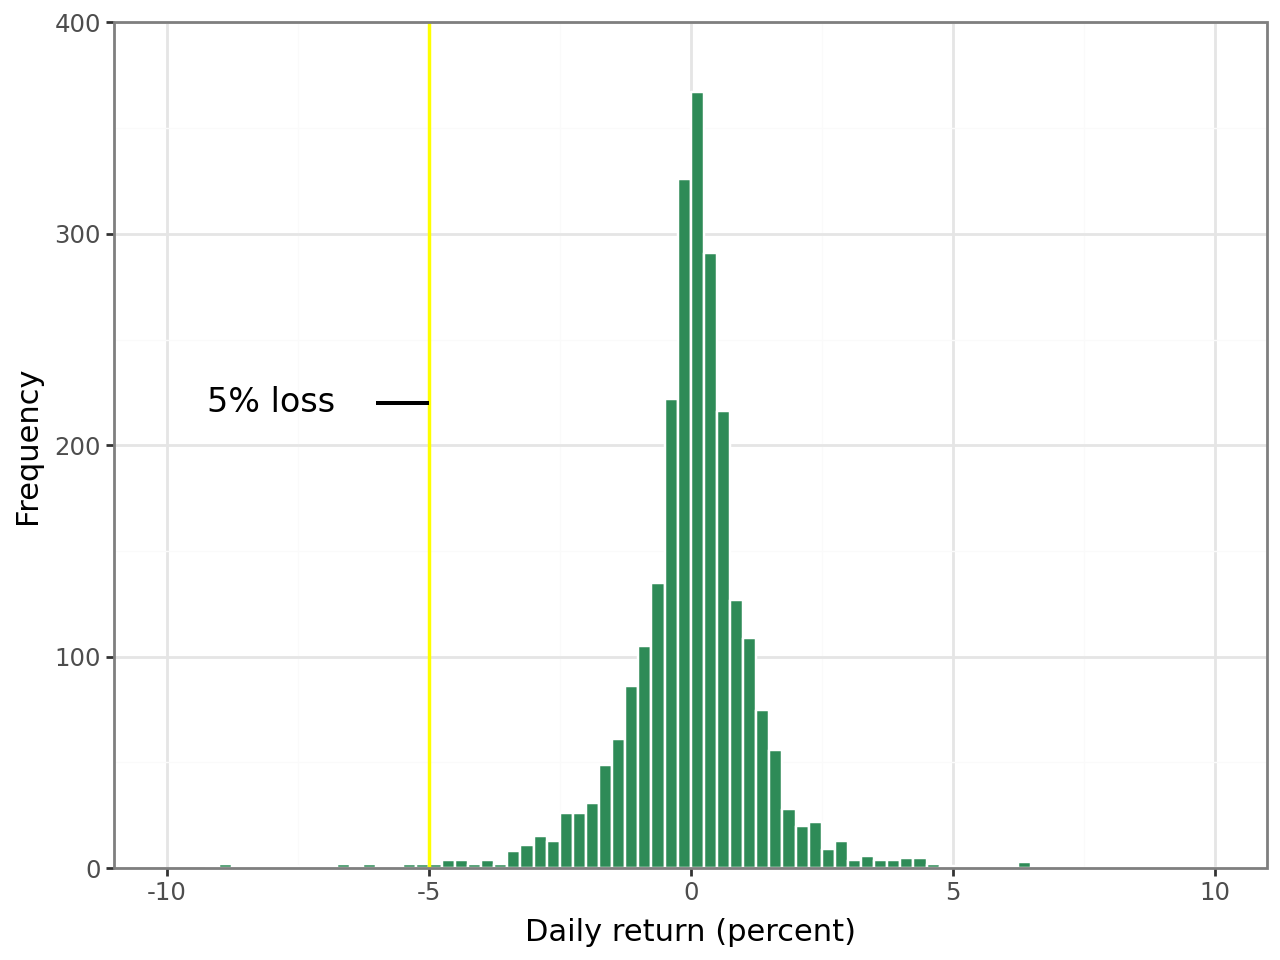

In [8]:
(
    ggplot(sp500, aes("pct_return"))
    + geom_histogram(
        binwidth=0.25, color="white", fill="seagreen", boundary=0, closed="left"
    )
    + geom_vline(xintercept=-5, size=0.7, color="yellow")
    + labs(x="Daily return (percent)", y="Frequency")
    + coord_cartesian(xlim=[-10, 10], ylim=[0, 400])
    + scale_y_continuous(expand=[0, 0])
    + geom_segment(aes(x=-6, y=220, xend=-5, yend=220))
    + annotate("text", x=-8, y=220, label="5% loss", size=12)
    + theme_bw()
)


In [9]:
sp500["pct_return"].describe()

count    2518.000000
mean        0.029145
std         1.315438
min        -9.034980
25%        -0.453734
50%         0.070897
75%         0.582782
max        11.580036
Name: pct_return, dtype: float64

In [10]:
sp500max=sp500.loc[sp500["pct_return"].idxmax()]
sp500max

DATE          2008-10-13 00:00:00
VALUE                     1003.35
pct_return              11.580036
year                         2008
month                          10
yearmonth                  200810
Name: 536, dtype: object

In [11]:
sp500.count()
sp500
sp500less5 = sp500.loc[sp500["pct_return"] < -5].reset_index(drop=True)
sp500less5["pct_return_decimal"] = sp500less5["pct_return"] / 100
sp500less5

,DATE,VALUE,pct_return,year,month,yearmonth,pct_return_decimal
0,2008-09-29,1106.39,-8.789705,2008,9,200809,-0.087897
1,2008-10-07,996.23,-5.739481,2008,10,200810,-0.057395
2,2008-10-09,909.92,-7.616708,2008,10,200810,-0.076167
3,2008-10-15,907.84,-9.034980,2008,10,200810,-0.090350
4,2008-10-22,896.78,-6.101251,2008,10,200810,-0.061013
5,2008-11-05,952.77,-5.267711,2008,11,200811,-0.052677
6,2008-11-06,904.88,-5.026397,2008,11,200811,-0.050264
7,2008-11-12,852.30,-5.189388,2008,11,200811,-0.051894
8,2008-11-19,806.58,-6.115560,2008,11,200811,-0.061156
9,2008-11-20,752.44,-6.712291,2008,11,200811,-0.067123


In [12]:
sp500less5['DATE'].min(), sp500less5['DATE'].max()

(Timestamp('2008-09-29 00:00:00'), Timestamp('2011-08-08 00:00:00'))

In [13]:
sp500less5["pct_return"].mean()

np.float64(-6.65138836502497)

In [14]:
true_share = (sp500["pct_return"] <= -5).mean()
print(true_share)

0.005160778086542279


### Figure 5.2 prep

 Create 10 000 samples, with 500 and 1000 observations in each sample, taken from sp500["pct_return"]

In every sample: for each observation, check if it is a loss of 5% or more. Then calculate the percentage of observations out of 500 or 1000 where the loss exceeds 5%. 

In [15]:
from importlib import import_module

# Try to import create_sample_frame from the func directory
create_sample = import_module("func_sample")  # replace with actual filename without .py
create_sample_frame = create_sample.create_sample_frame

help(create_sample_frame)

ModuleNotFoundError: No module named 'func_sample'

In [16]:
n_samples = 10000  # Define the number of samples

# For n=1000
samples_1000 = np.random.choice(sp500["pct_return"].dropna(), size=(n_samples, 1000), replace=True)
a=samples_1000 < -5

nobs_1000 = np.mean(samples_1000 < -5, axis=1)

# For n=500
samples_500 = np.random.choice(sp500["pct_return"].dropna(), size=(n_samples, 500), replace=True)
nobs_500 = np.mean(samples_500 < -5, axis=1)


In [17]:
a = pd.DataFrame(a)
a

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
nobs_df = pd.DataFrame({"nobs_500": nobs_500, "nobs_1000": nobs_1000})*100

In [19]:
a = pd.DataFrame(samples_1000).T
a

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-0.500971,-0.388354,-0.024105,0.112478,0.608094,-0.341815,1.636567,-1.887093,-1.587730,0.196335,...,-0.396539,-2.086615,-1.399036,1.355424,-0.339734,-3.441147,-1.864846,0.448111,0.733654,1.097604
1,-0.948677,-0.268988,1.721898,1.604340,-0.682541,-0.356363,-0.121338,0.690061,0.652441,-2.086615,...,0.109392,0.216028,0.773903,0.058874,2.828008,0.058874,0.196335,0.318321,0.218365,0.949723
2,1.655658,-0.187016,0.583629,-0.725654,0.204345,1.708044,-0.038473,0.014979,-0.089392,0.082173,...,-0.429493,-0.348036,-0.281678,2.508302,-1.675761,0.766254,-2.370042,0.404152,-0.256101,1.219218
3,-1.172575,0.550949,0.483726,0.340861,0.536711,0.476081,-0.614777,-1.419600,-1.183737,0.511410,...,0.072513,-0.414089,0.147098,-0.058832,0.044823,0.192476,0.376473,3.386817,-0.175270,1.006275
4,0.186458,-0.833128,-0.618435,0.811606,0.708048,0.881676,-2.296630,0.151617,-5.267711,0.017288,...,-2.311751,1.353365,-2.492498,-0.956155,1.431527,-0.588736,-0.024599,-0.888956,-0.034685,-0.810034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.684752,-1.264914,0.561647,-1.415388,-0.841038,0.751676,-0.296614,0.466566,-0.223265,10.789002,...,0.552856,1.679735,1.755586,-0.886334,0.156926,0.702847,-2.212381,0.494808,1.718713,3.589627
996,0.173084,1.311997,-0.414130,-6.115560,-0.071013,0.310587,-0.371741,1.137034,-0.704877,0.486334,...,-1.342149,0.751676,-2.226173,2.183048,0.160622,0.702847,0.914266,-1.537018,-2.817869,0.197969
997,-0.618435,-1.743188,1.030010,0.598189,-0.581306,-0.354538,1.287301,0.941270,0.057490,-0.326134,...,-1.289589,-0.369818,0.202331,0.038923,-1.430722,-1.135843,-0.101054,0.612649,-0.332827,0.072513
998,-0.370877,0.271471,1.662754,-0.147597,0.350321,-0.062904,0.128296,-0.026972,0.120986,0.959050,...,-2.930840,-2.214101,1.068059,0.187121,1.957448,0.759743,-0.630312,0.603009,2.920800,-0.095633


In [20]:
nobs_df

,nobs_500,nobs_1000
0,0.4,0.5
1,1.0,0.5
2,1.0,0.4
3,0.8,1.1
4,0.2,1.1
...,...,...
9995,0.4,0.4
9996,0.2,0.6
9997,0.6,0.6
9998,0.4,0.5


In [21]:
error = (
    norm.ppf(0.975) * np.std(nobs_df["nobs_1000"]) / np.sqrt(len(nobs_df["nobs_1000"]))
)
left = np.mean(nobs_df["nobs_1000"]) - error
right = np.mean(nobs_df["nobs_1000"]) + error


### Figure 5.2

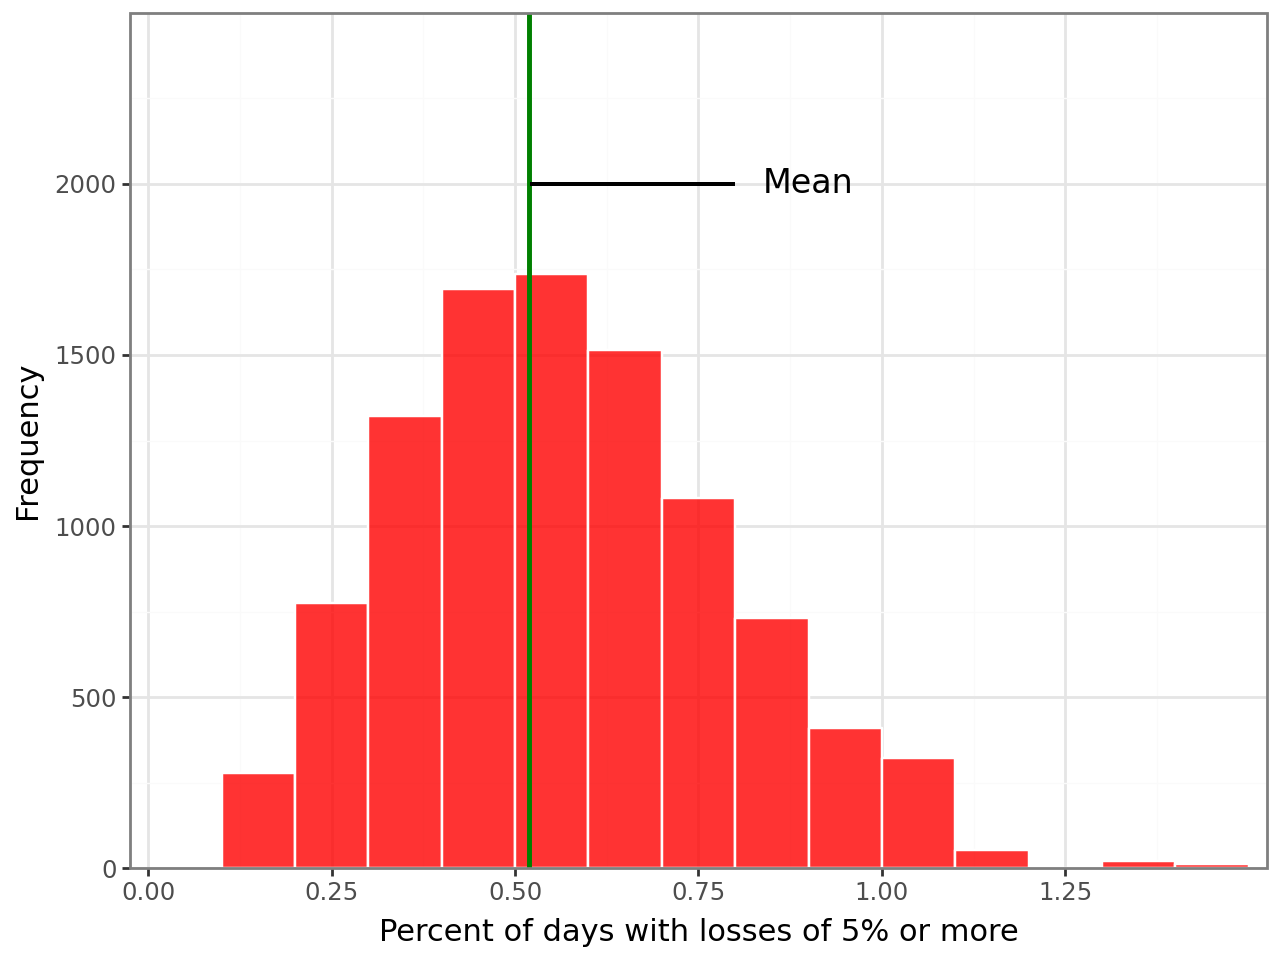

In [22]:
(
    ggplot(nobs_df, aes("nobs_1000"))
    + geom_histogram(
        binwidth=0.1,
        color="white",
        fill="red",
        alpha=0.8,
        center=0.75,
        closed="left",
    )
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + geom_vline(aes(xintercept=nobs_df["nobs_1000"].mean()), color="green", size=1)
    + coord_cartesian(xlim=[0, 1.5], ylim=(0, 2500))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=np.arange(0, 1.5, 0.25))
    + scale_y_continuous(
        expand=(0.00, 0.00), limits=(0, 2500), breaks=np.arange(0, 2500, 500)
    )
    + geom_segment(aes(x=0.8, y=2000, xend=0.52, yend=2000))
    + annotate("text", x=0.9, y=2000, label="Mean", size=12)
    + theme_bw()
)

In [23]:
nobs_df["nobs_1000"].std()

np.float64(0.2296257590056479)

In [27]:
nobs_df["nobs_500"].std()

np.float64(0.32121591113479514)

In [24]:
nobs_df["nobs_1000"].mean()

np.float64(0.51906)

In [28]:
nobs_df["nobs_500"].mean()

np.float64(0.5224200000000001)

### Figure 5.3 

Not working with epanechnikov kernel

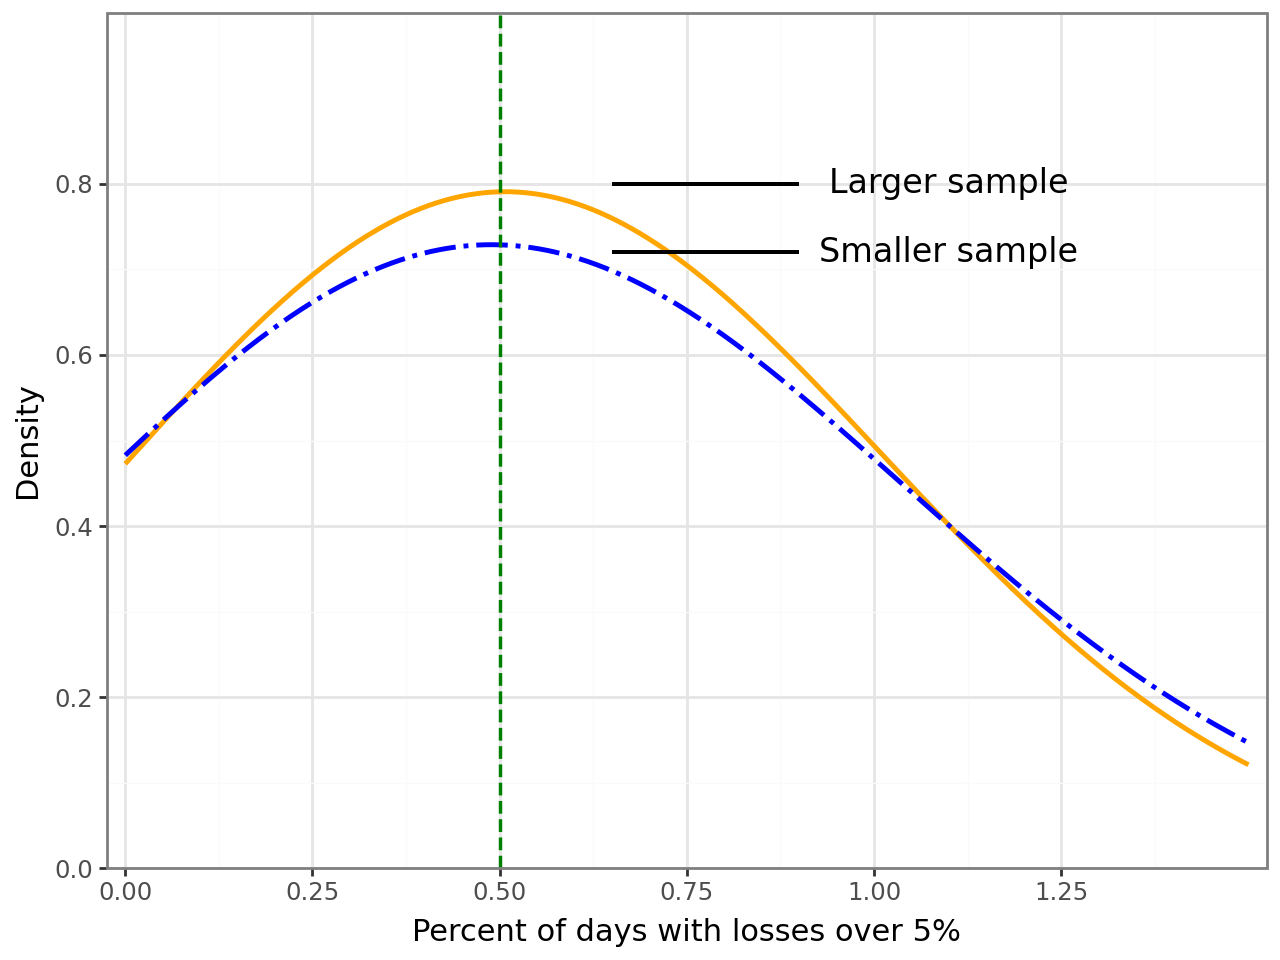

In [25]:
(
    ggplot(nobs_df)
    + stat_density(aes(x="nobs_1000"), color="orange", geom="line", bw=0.45, size=1)
    + stat_density(
        aes("nobs_500"),
        color="blue",
        geom="line",
        bw=0.45,
        linetype="dashdot",
        size=1,
    )
    + labs(x="Percent of days with losses over 5%", y="Density")
    + geom_vline(xintercept=0.5, color="green", size=0.7, linetype="dashed")
    + geom_segment(aes(x=0.9, y=0.8, xend=0.65, yend=0.8), size=0.5)
    + annotate("text", x=1.1, y=0.8, label="Larger sample", size=12)
    + geom_segment(aes(x=0.9, y=0.72, xend=0.65, yend=0.72), size=0.5)
    + annotate("text", x=1.1, y=0.72, label="Smaller sample", size=12)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=np.arange(0, 1.5, 0.25))
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 1), breaks=np.arange(0, 1, 0.2))
    + theme_bw()
    + theme(
        legend_position="none",
    )
)

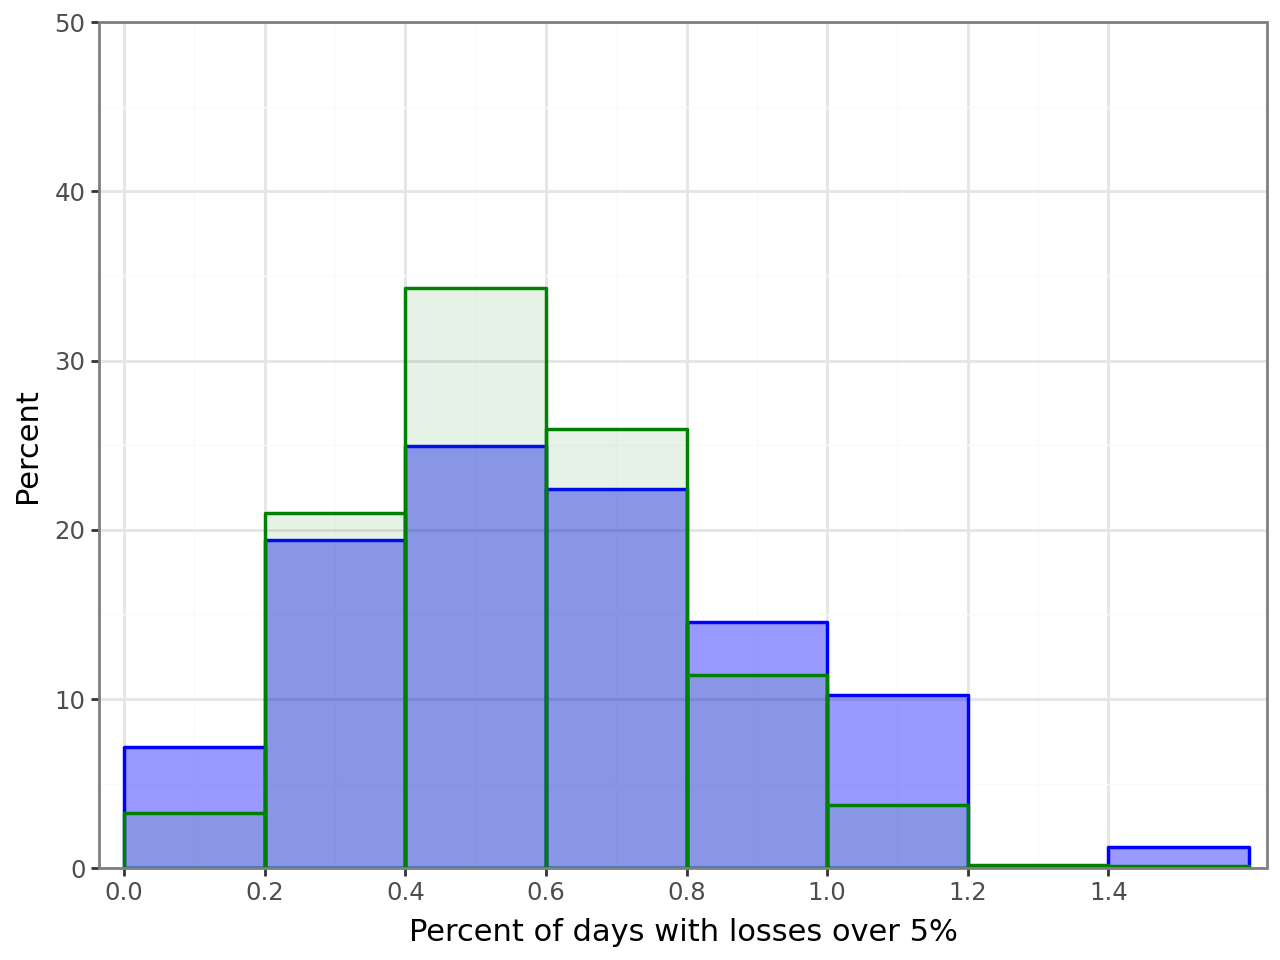

In [26]:
(
    ggplot(nobs_df)
    + geom_histogram(
        aes(x="nobs_500", y="stat(count)/sum(stat(count))*100"),
        color="blue",
        fill="blue",
        binwidth=0.2,
        center=0.5,
        size=0.7,
        alpha=0.4,
        closed="left",
    )
    + geom_histogram(
        aes(x="nobs_1000", y="stat(count)/sum(stat(count))*100"),
        color="green",
        fill="green",
        binwidth=0.2,
        center=0.5,
        alpha=0.1,
        size=0.7,
        closed="left",
    )
    + ylab("Percent")
    + xlab("Percent of days with losses over 5%")
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(-0.01, 1.6), breaks=np.arange(0, 1.6, 0.2)
    )
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 50))
    + scale_color_manual(
        labels=("N = 1000", "N = 500"), name="", values=("blue", "green")
    )
    + scale_alpha_identity()
    + scale_fill_identity()
    + theme_bw()
    + theme(
        legend_direction="horizontal",
    )
)


Create bootstrap samples

In [ ]:
bootstrap_samples = create_sample_frame(
    sp500["pct_return"], len(sp500["pct_return"]), with_replacement=True
)

Calculate percent of days wit losses over  thresholds from -1 to 10

In [ ]:
bootstrap_loss_results = pd.DataFrame(
    [
        np.mean(bootstrap_samples < -1 * pct_loss, axis=1) * 100
        for pct_loss in range(1, 11)
    ],
    index=[f"loss{i}" for i in range(1, 11)],
).T

Plot percent of days with losses over -5%

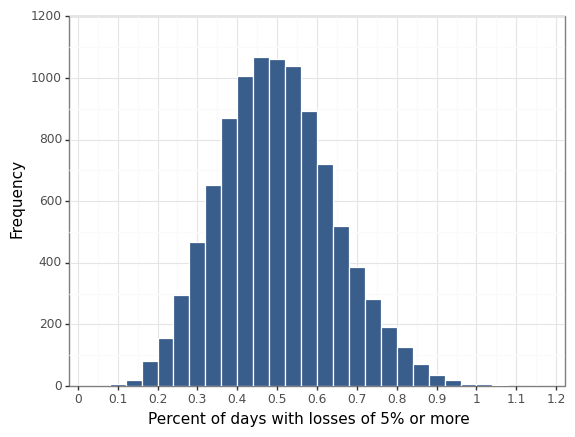

<ggplot: (678354791)>

In [ ]:
(
    ggplot(bootstrap_loss_results, aes("loss5"))
    + geom_histogram(
        fill=color[0], color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=seq(0, 1200, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=seq(0, 1.2, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)
